In [1]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import scipy as sp
import pvalannot
#import statsmodels
from sklearn.decomposition import PCA
from sklearn import preprocessing
from statsmodels.stats import multitest

In [2]:
groupDf = []

for group in range(16):
    df = pd.read_csv("KIR_Group_%d_final_genotype.tsv"%group, sep="\t")
    df["sample"] = df["sample"].map(lambda x: x.split("_")[0])
    print(df)
    groupDf.append(df)

       sample  KIR2DL4*001  KIR2DS4*001  KIR3DL1*015  KIR3DL2*002  \
0  SRR7059136    35.988679   188.644857    51.488741    42.182868   
1  SRR7059137   305.737364    98.076383     3.217969    27.384261   

   KIR3DL2*008  inconsistency  
0    86.675191            NaN  
1    87.249180            NaN  
       sample  KIR2DL3*001  KIR2DL4*001  KIR2DL4*011  KIR3DL1*015  \
0  SRR7059138   117.140331    41.880678    59.357337    50.583660   
1  SRR7059139    67.673014   573.129119   232.292993    44.752484   

   inconsistency  
0            NaN  
1            NaN  
       sample  KIR2DL1*003  KIR2DL3*001  KIR2DL4*005  KIR2DL4*006  \
0  SRR7059140    47.737039   323.926976    40.952022    98.229492   
1  SRR7059141    73.534186   723.501884    64.589725   135.231976   

   KIR2DS1*002  KIR2DS3*002  KIR3DL2*007  KIR3DL2*008  KIR3DS1*013  \
0   297.919428    25.840088    89.630102   167.765628    56.837970   
1     0.000000    78.522149   192.997301   229.463607   349.845356   

   inconsist

In [3]:
groupDf[0],groupDf[1]

(       sample  KIR2DL4*001  KIR2DS4*001  KIR3DL1*015  KIR3DL2*002  \
 0  SRR7059136    35.988679   188.644857    51.488741    42.182868   
 1  SRR7059137   305.737364    98.076383     3.217969    27.384261   
 
    KIR3DL2*008  inconsistency  
 0    86.675191            NaN  
 1    87.249180            NaN  ,
        sample  KIR2DL3*001  KIR2DL4*001  KIR2DL4*011  KIR3DL1*015  \
 0  SRR7059138   117.140331    41.880678    59.357337    50.583660   
 1  SRR7059139    67.673014   573.129119   232.292993    44.752484   
 
    inconsistency  
 0            NaN  
 1            NaN  )

In [5]:
sraToPhenotype = {}

srxToSrr = {}
srrToPhenotype = {}

fp = open("PRJNA453180_SraRunInfo.csv")
line = fp.readline()
for line in fp:
    cols = line.rstrip().split(",")
    if (len(cols) > 1):
        srxToSrr[cols[10]] = cols[0]
fp.close()   

fp = open("PRJNA453183_SraRunInfo.csv")
line = fp.readline()
for line in fp:
    cols = line.rstrip().split(",")
    if (len(cols) > 1):
        srxToSrr[cols[10]] = cols[0]
fp.close()   

fp = open("PRJNA453180_sra_result.csv")
line = fp.readline()
for line in fp:
    cols = line.rstrip().split(",")
    for i, c in enumerate(cols):
        cols[i] = c[1:-1]
    if (len(cols) > 1):
        #print(cols)
        srr = srxToSrr[cols[0]]
        phenotype = " ".join(cols[1].split(";")[0].split(" ")[-6:])
        cellid = phenotype.split(" ")[-1]
        if ("memory" in phenotype):
            phenotype = "Blood memory CD8 T cells " + cellid
        elif ("Naive" in phenotype):
            phenotype = "Blood naive CD8 T cells " + cellid
        elif ("CD39-" in phenotype):
            phenotype = "NSCLC CD39- CD8 T cells " + cellid
        elif ("CD39+" in phenotype):
            phenotype = "NSCLC CD39+ CD8 T cells " + cellid
        srrToPhenotype[srr] = phenotype
fp.close()

fp = open("PRJNA453183_summary.tsv")
line = fp.readline()
for line in fp:
    cols = line.rstrip().split("\t")
    if (len(cols) > 1):
        #print(cols)
        srr = srxToSrr[cols[0]]
        phenotype = " ".join(cols[1].split(";")[0].split(" ")[-6:])
        cellid = phenotype.split(" ")[-1]
        if ("memory" in phenotype):
            phenotype = "Blood memory CD8 T cells " + cellid
        elif ("Naive" in phenotype):
            phenotype = "Blood naive CD8 T cells " + cellid
        elif ("CD39-" in phenotype):
            phenotype = "CRC CD39- CD8 T cells " + cellid
        elif ("CD39+" in phenotype):
            phenotype = "CRC CD39+ CD8 T cells " + cellid
        srrToPhenotype[srr] = phenotype
fp.close()

In [6]:
for i in range(len(groupDf)):
    df = groupDf[i]
    df["phenotype"] = [srrToPhenotype[s] for s in df["sample"]] 
    groupDf[i] = df.drop(columns = ["inconsistency", "sample"], axis=1)

In [7]:
groupDf[0]

,KIR2DL4*001,KIR2DS4*001,KIR3DL1*015,KIR3DL2*002,KIR3DL2*008,phenotype
0,35.988679,188.644857,51.488741,42.182868,86.675191,NSCLC CD39- CD8 T cells 1
1,305.737364,98.076383,3.217969,27.384261,87.249180,NSCLC CD39+ CD8 T cells 1


In [5]:
srrToPhenotype

{'SRR7059143': 'NSCLC CD39+ CD8 T cells 4',
 'SRR7059142': 'NSCLC CD39- CD8 T cells 4',
 'SRR7059141': 'NSCLC CD39+ CD8 T cells 3',
 'SRR7059140': 'NSCLC CD39- CD8 T cells 3',
 'SRR7059139': 'NSCLC CD39+ CD8 T cells 2',
 'SRR7059138': 'NSCLC CD39- CD8 T cells 2',
 'SRR7059137': 'NSCLC CD39+ CD8 T cells 1',
 'SRR7059136': 'NSCLC CD39- CD8 T cells 1',
 'SRR7059170': 'CRC CD39+ CD8 T cells 6',
 'SRR7059169': 'CRC CD39+ CD8 T cells 5',
 'SRR7059168': 'CRC CD39+ CD8 T cells 4',
 'SRR7059167': 'CRC CD39+ CD8 T cells 3',
 'SRR7059166': 'CRC CD39+ CD8 T cells 2',
 'SRR7059165': 'CRC CD39+ CD8 T cells 1',
 'SRR7059164': 'CRC CD39- CD8 T cells 7',
 'SRR7059163': 'CRC CD39- CD8 T cells 6',
 'SRR7059162': 'CRC CD39- CD8 T cells 5',
 'SRR7059161': 'CRC CD39- CD8 T cells 4',
 'SRR7059160': 'CRC CD39- CD8 T cells 3',
 'SRR7059159': 'CRC CD39- CD8 T cells 2',
 'SRR7059158': 'CRC CD39- CD8 T cells 1',
 'SRR7059157': 'Blood naive CD8 T cells 4',
 'SRR7059156': 'Blood naive CD8 T cells 3',
 'SRR7059155':

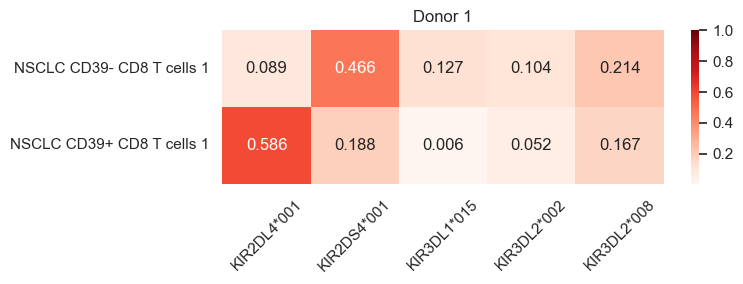

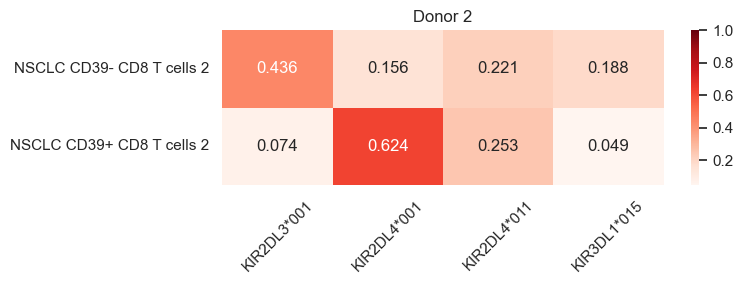

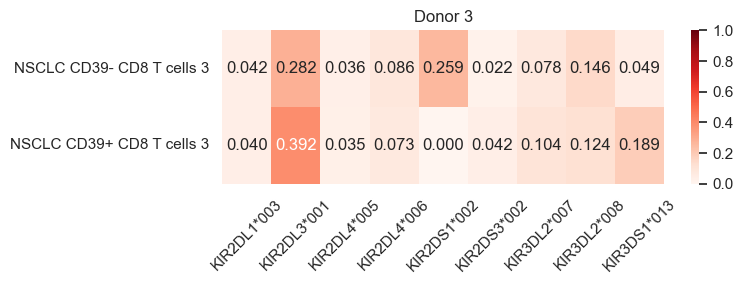

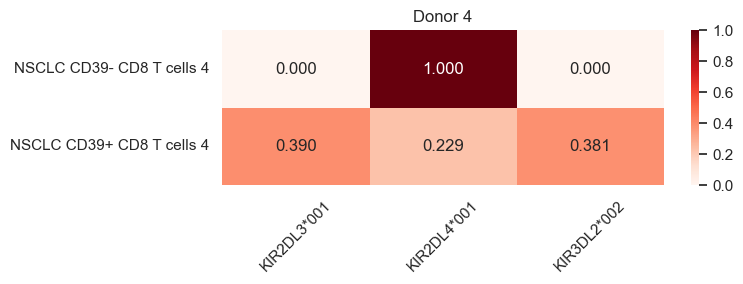

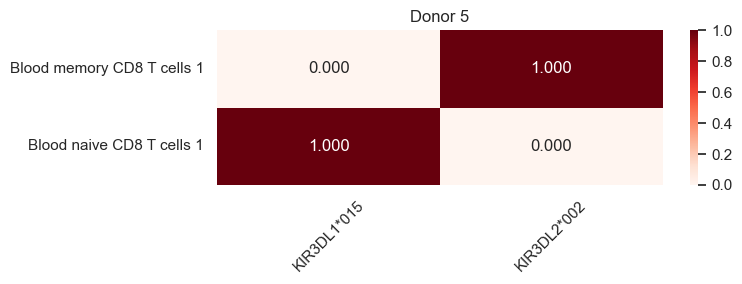

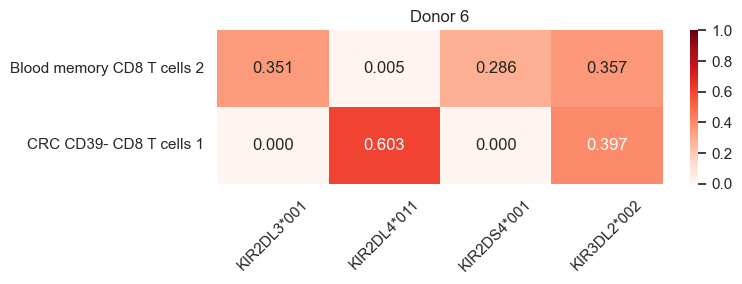

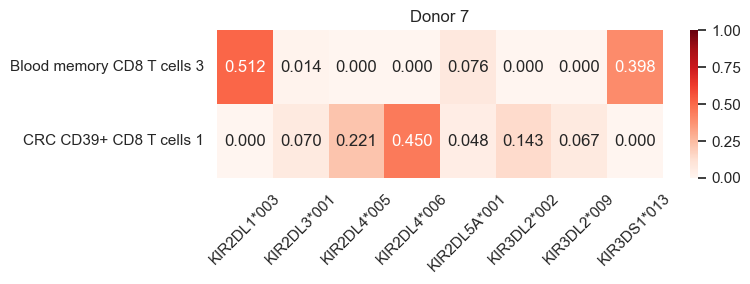

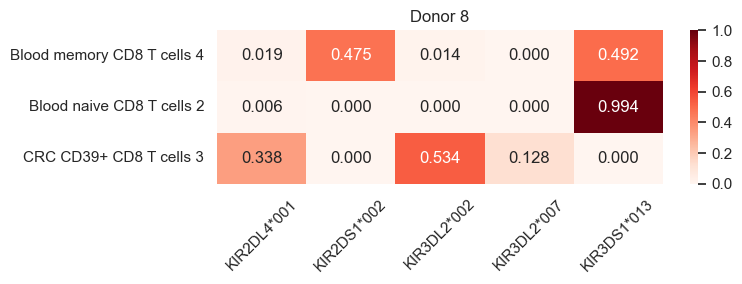

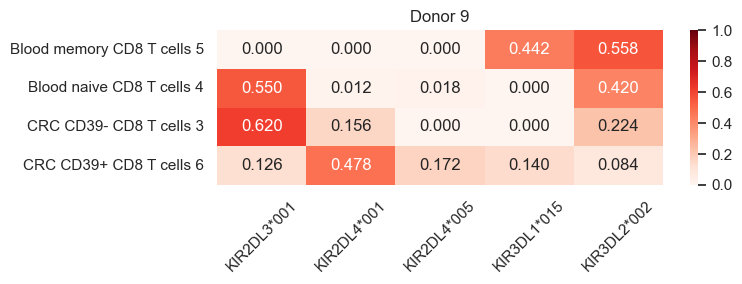

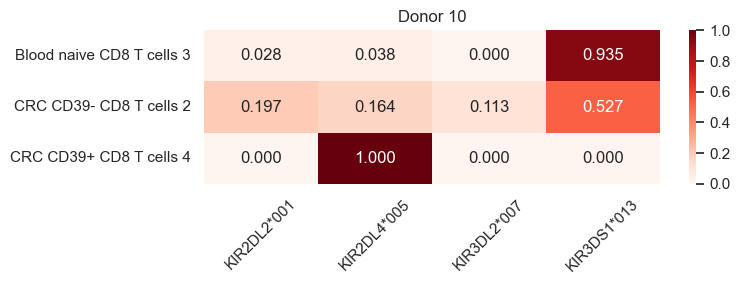

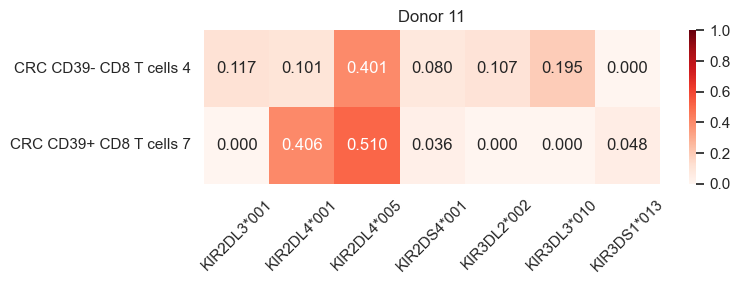

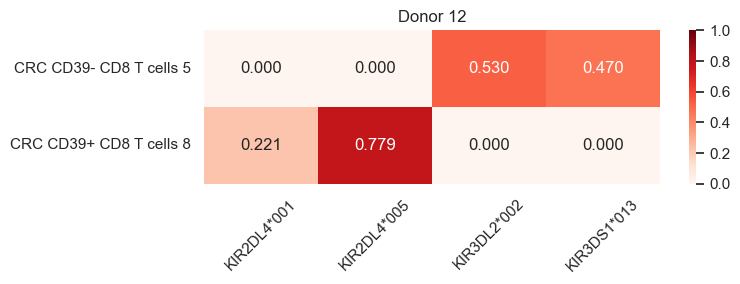

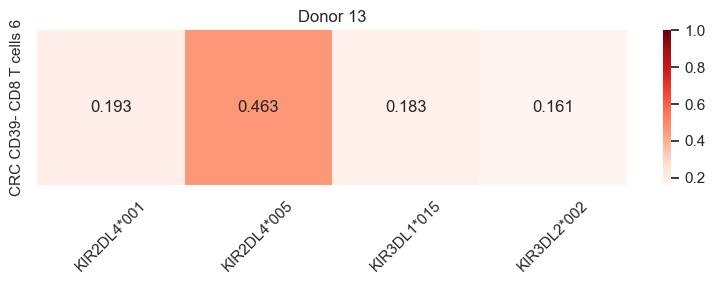

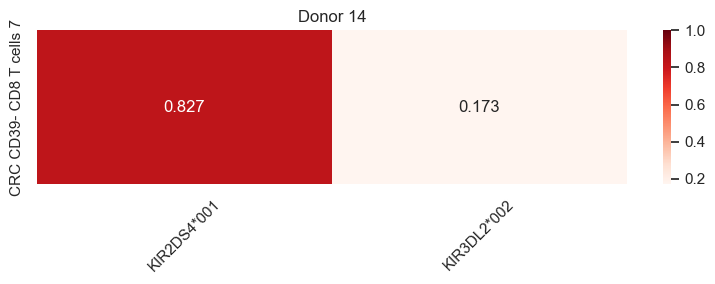

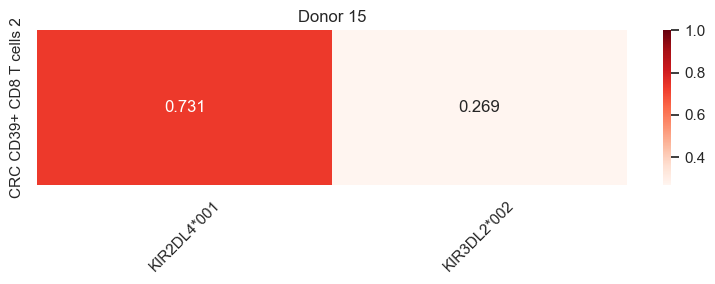

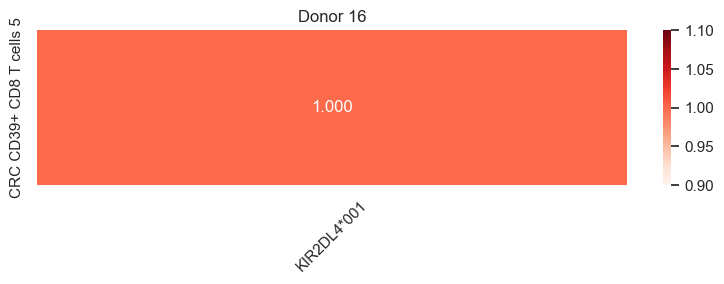

In [8]:
for i in range(len(groupDf)):
    plt.figure(figsize=(8, 3))
    df = groupDf[i]
    heatmapDf = df.set_index("phenotype")
    normalizedHeatmapDf = heatmapDf.div(heatmapDf.sum(axis=1), axis=0)
    sns.set(style="white")
    snsFig = sns.heatmap(normalizedHeatmapDf, cmap="Reds", annot=True,
                        fmt=".3f", vmax=1)
    snsFig.set(ylabel="", title=f"Donor {i+1}")
    for tick in snsFig.get_xticklabels():
        tick.set_rotation(45)
    plt.tight_layout()
    plt.savefig(f"smartseq_heatmap_group{i}.png", dpi=300)
    plt.show()

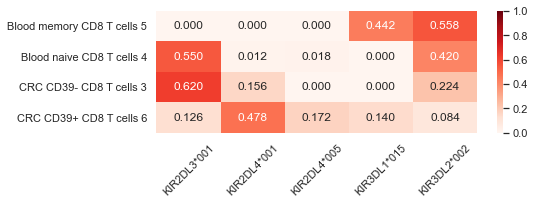

In [165]:
for i in [8]:
    plt.figure(figsize=(8, 3))
    df = groupDf[i]
    heatmapDf = df.set_index("phenotype")
    normalizedHeatmapDf = heatmapDf.div(heatmapDf.sum(axis=1), axis=0)
    sns.set(style="white")
    snsFig = sns.heatmap(normalizedHeatmapDf, cmap="Reds", annot=True,
                        fmt=".3f", vmax=1)
    snsFig.set(ylabel="")
    for tick in snsFig.get_xticklabels():
        tick.set_rotation(45)
    plt.tight_layout()
    plt.savefig("smartseq_heatmap_group8.pdf", format="pdf")
    plt.show()
    #plt.savefig("smartseq_heatmap.pdf", format="pdf")

In [ ]:
# FPK value
for i in range(len(groupDf)):
    plt.figure(figsize=(8, 3))
    df = groupDf[i]
    heatmapDf = df.set_index("phenotype")
    #normalizedHeatmapDf = heatmapDf.div(heatmapDf.sum(axis=1), axis=0)
    sns.set(style="white")
    snsFig = sns.heatmap(heatmapDf, cmap="Reds", annot=True,
                        fmt=".0f")
    snsFig.set(ylabel="", title=f"Donor {i+1}")
    for tick in snsFig.get_xticklabels():
        tick.set_rotation(45)
    plt.tight_layout()
    plt.savefig(f"smartseq_heatmap_group{i}_FPK.png", dpi=300)
    plt.show()

In [35]:
# Check the allele occurent distribution
kirList = ["KIR2DL1","KIR2DL2","KIR2DL3","KIR2DL4","KIR2DL5A","KIR2DL5B",
           "KIR2DP1","KIR2DS1","KIR2DS2","KIR2DS3","KIR2DS4",
           "KIR2DS5","KIR3DL1","KIR3DL2","KIR3DL3","KIR3DP1","KIR3DS1"]

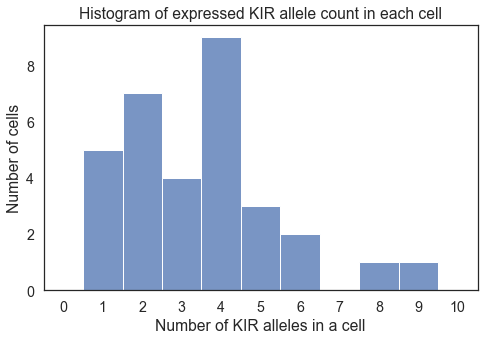

In [43]:
# Distribution of the number of KIR alleles in a sample
kirCount = {}
for df in groupDf:
    for row in df.iterrows():
        phenotype = row[1]["phenotype"]
        kirCount[phenotype] = 0
        for key, val in row[1].items():
            if (key == "phenotype"):
                continue
            if (val > 0):
                kirCount[phenotype] += 1
        
#kirCount[sample] = 0 
tmpDf = pd.DataFrame()
tmpDf["phenotype"] = kirCount.keys()
tmpDf["Count"] = kirCount.values()
fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style="white", font_scale=1.3)
#ax = sns.histplot(x="Count", data=tmpDf)
ax = sns.histplot(x="Count", data=tmpDf, binrange=(0, len(kirList) + 1), discrete=True,
                 color = sns.color_palette()[0])
ax.set_xticks(range(11))
ax.set(ylabel = "Number of cells", xlabel = "Number of KIR alleles in a cell", 
       title = "Histogram of expressed KIR allele count in each cell",
      xlim=(-0.5, 10.5))
plt.tight_layout()
plt.savefig("smartseq_num_allele_in_samples.pdf", format="pdf")

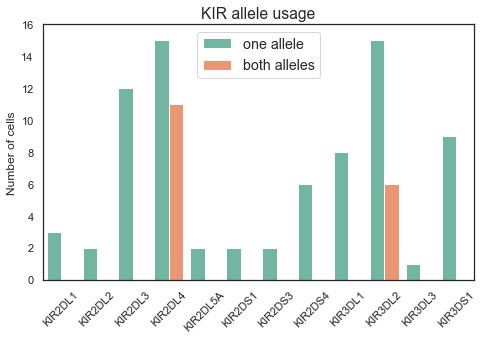

In [11]:
# Distribution of the number of samples a KIR allele shows up in.
kirCount = {}
for df in groupDf:
    for row in df.iterrows(): # each row is a cell
        tmp = {}
        for key, val in row[1].items():
            if (key == "phenotype"):
                continue
            if (val > 0):
                key = key.split("*")[0]
                if (key not in tmp):
                    tmp[key] = 0
                tmp[key] += 1
        for key, count in tmp.items():
            if (key not in kirCount):
                kirCount[key] = {1:0, 2:0}
            kirCount[key][count] += 1
    #kirCount[sample] = 0 
kirv = []
countv = []
alleleCntv = []

for kir in kirCount:
    for i in range(1, 3):
        kirv.append(kir)
        countv.append(kirCount[kir][i])
        alleleCntv.append(i)
tmpDf = pd.DataFrame({"KIR":kirv, "Count":countv, "alleleCnt": alleleCntv})
#ax = sns.histplot(x="Count", data=tmpDf)
#color = sns.color_palette()[0]
fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style="white", font_scale=1.3)
ax = sns.barplot(x="KIR", y="Count", data=tmpDf, order=sorted(set(kirv)), 
                 hue = "alleleCnt", hue_order = [1, 2],
                palette="Set2")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["one allele", "both alleles"])
#ax.set(ylabel = "# of samples")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
#ax.set_yticks([0,5,10,15])
ax.set(ylabel="Number of cells", xlabel="", title="KIR allele usage",
      ylim=(0, 16))
plt.tight_layout()
plt.savefig("smartseq_num_samples_for_allele.pdf", format="pdf")

In [12]:
%load_ext autoreload
%autoreload 2

{(('KIR2DL1', 'CD39+'), ('KIR2DL1', 'CD39-')): (0.0, 1.0), (('KIR2DL2', 'CD39+'), ('KIR2DL2', 'CD39-')): (0.0, 1.0), (('KIR2DL3', 'CD39+'), ('KIR2DL3', 'CD39-')): (5.0, 1.0), (('KIR2DL4', 'CD39+'), ('KIR2DL4', 'CD39-')): (31.0, 0.006068706512451172), (('KIR2DS1', 'CD39+'), ('KIR2DS1', 'CD39-')): (0.0, 1.0), (('KIR2DS3', 'CD39+'), ('KIR2DS3', 'CD39-')): (0.0, 1.0), (('KIR2DS4', 'CD39+'), ('KIR2DS4', 'CD39-')): (0.0, 1.0), (('KIR3DL1', 'CD39+'), ('KIR3DL1', 'CD39-')): (3.0, 1.0), (('KIR3DL2', 'CD39+'), ('KIR3DL2', 'CD39-')): (25.0, 0.9224853515625), (('KIR3DL3', 'CD39+'), ('KIR3DL3', 'CD39-')): (0.0, 1.0), (('KIR3DS1', 'CD39+'), ('KIR3DS1', 'CD39-')): (3.0, 1.0)}


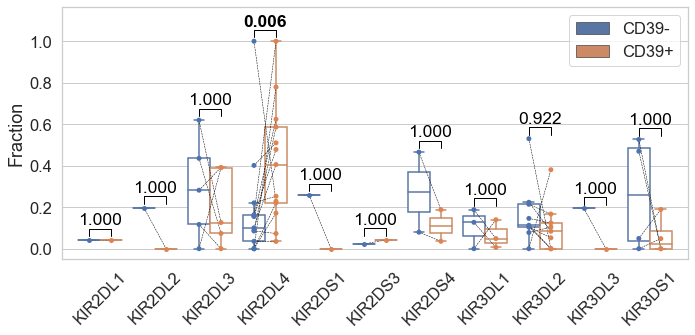

In [31]:
fracv = []
genev = []
allelev = []
groupv = []
typev = []

pairv = {}
for i, df in enumerate(groupDf):
    df = df.set_index("phenotype")
    df = df.div(df.sum(axis=1), axis=0)
    plusDf = df.loc[ df.index.str.contains("CD39\+")]
    minusDf = df.loc[ df.index.str.contains("CD39-")]
    if (len(plusDf) != 1 or len(minusDf) != 1):
        continue
    cols = list(df.columns)
    for c in cols:
        if (c == "phenotype"):
            continue
        gene = c.split("*")[0]
        genev.extend([gene, gene])
        allelev.extend([c,c])
        fracv.extend([plusDf[c].iloc[0], minusDf[c].iloc[0]])
        typev.extend(["CD39+", "CD39-"])
        groupv.extend([i,i])
        if (gene not in pairv):
            pairv[gene] = []
        pairv[gene].append([minusDf[c].iloc[0], plusDf[c].iloc[0]])
    
kirCount = {}
for g in genev:
    if (g not in kirCount):
        kirCount[g] = 0
    kirCount[g] += 1
selectedKirs = set({})
for g in kirCount:
    if (kirCount[g] > 0):
        selectedKirs.add(g)
plotDf = pd.DataFrame({"Fraction":fracv, "Type":typev, "Gene":genev, "Allele":allelev,
                  "Patient":groupv})
plotDf = plotDf.loc[plotDf["Gene"].isin(selectedKirs)]
xorder = sorted(selectedKirs)
geneRank = {}
for i, x in enumerate(xorder):
    geneRank[x] = i
sns.set(font_scale=1.5, style="whitegrid")
fig = plt.figure(figsize=(10, 5))
snsFig = sns.boxplot(x = "Gene", y = "Fraction", data = plotDf, 
                 hue = "Type", order=xorder, hue_order = ["CD39-", "CD39+"], 
                     showfliers=False)

for i,box in enumerate([p for p in snsFig.patches if not p.get_label()]): 
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')
    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         snsFig.lines[j].set_color(color)
handles, labels = snsFig.get_legend_handles_labels()
snsFig = sns.stripplot(x = "Gene", y="Fraction", data=plotDf,
                      hue = "Type", order=xorder, hue_order = ["CD39-", "CD39+"],
                      dodge=True, jitter=False, ax = snsFig)

snsFig.set(xlabel="")
snsFig.legend(handles, labels)

for gene in pairv:
    x = geneRank[gene]
    for p in pairv[gene]:
        snsFig.plot([x-0.2, x+0.2], [p[0], p[1]], "--", color="black", 
                    linewidth=0.5)
for tick in snsFig.get_xticklabels():
    tick.set_rotation(45)
    
pval=pvalannot.AddPvalAnnot(x="Gene", y = "Fraction", data=plotDf,
                     hue="Type", order=xorder, hue_order = ["CD39-", "CD39+"],
                      ax=snsFig, pair_test_key="Patient", styles=["bold_significant"],
                      fmt="%.3f", func=sp.stats.wilcoxon,
                    padjust_func = lambda x: multitest.multipletests(x, method="fdr_bh")[1])

#pval=pvalannot.AddPvalAnnot(x="Gene", y = "Fraction", data=plotDf,
#                     hue="Type", order=xorder, hue_order = ["CD39-", "CD39+"],
#                      ax=snsFig, styles=["bold_significant"],
#                      fmt="%.3f")
plt.tight_layout()
plt.savefig("smartseq_KIR_diff.pdf", format="pdf")
print(pval)